In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
votes = pd.read_csv("votes.csv")

In [3]:
data = pd.read_csv("data.csv")

### Data Cleaning & Augmentation ###

In [4]:
votes.fillna(-1, inplace=True)

In [5]:
data[data['ST'].isnull()]

,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,Median Earnings 2010,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population,Children Under 6 Living in Poverty,Adults 65 and Older Living in Poverty,Total Population,Preschool.Enrollment.Ratio.enrolled.ages.3.and.4,Poverty.Rate.below.federal.poverty.threshold,Gini.Coefficient,Child.Poverty.living.in.families.below.the.poverty.line,Management.professional.and.related.occupations,Service.occupations,Sales.and.office.occupations,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,White,Black,Hispanic,Asian,Amerindian,Other,White_Asian,SIRE_homogeneity,median_age,Low.birthweight,Teen.births,Children.in.single.parent.households,Adult.smoking,Adult.obesity,Diabetes,Sexually.transmitted.infections,HIV.prevalence.rate,Uninsured,Unemployment,Violent.crime,Homicide.rate,Injury.deaths,Infant.mortality
3115,Virginia,NaN,51515,"Bedford city, Virginia",NaN,NaN,15.5,84.5,20.8,7.9,68.6,23981.339685,70.6,22.75,0.05,0.7,2.0,3.95,47.95,6.7,6256,100.0,18.9,0.459,32.8,28.65,22.4,23.65,0.35,3.3,21.55,70.6,22.75,3.95,0.7,0.05,2.0,71.3,0.552202,43.1,0.09,47.8,0.612,NaN,0.301,0.128,323.6,343.9,0.155,0.086,297.03,NaN,97.2,NaN


In [6]:
data.at[3115, 'ST'] = 'VA'

In [7]:
#dropping duplicate columns as well as Infant Mortality and Homicide Rate, due to the abundance of missing values
data=data.drop(['White', 'Black', 'Hispanic', 'Asian', 'Amerindian', 'Other', 'White_Asian', 'Infant.mortality', 'Homicide.rate'], axis=1)
data=data.fillna(-1)

In [8]:
#renaming columns for consistency
data.rename(columns = {'Preschool.Enrollment.Ratio.enrolled.ages.3.and.4':'Preschool Enrollment Ratio (Ages 3 and 4)', 'Poverty.Rate.below.federal.poverty.threshold': 'Poverty Rate Below Federal Threshold', 'Gini.Coefficient': 'Gini Coefficient', 'Child.Poverty.living.in.families.below.the.poverty.line':'Children Living Below Poverty Line', 'Management.professional.and.related.occupations': 'Management Professionals et al.', 'Service.occupations': 'Service Occupations', 'Sales.and.office.occupations':'Sales and Office Occupations', 'Farming.fishing.and.forestry.occupations': 'Farming, Fishing, and Forestry Occupations', 'Construction.extraction.maintenance.and.repair.occupations':'Construction, Extraction, Maintenance and Repair Occupations', 'Production.transportation.and.material.moving.occupations': 'Production, Transportation and Material Moving Occupations', 'SIRE_homogeneity': 'SIRE Homogeneity', 'median_age': 'Median Age', 'Low.birthweight': 'Low Birthweight', 'Teen.births': 'Teen Births', 'Children.in.single.parent.households': 'Children in Single Parent Households', 'Adult.smoking': 'Adult Smoking Rate', 'Adult.obesity':'Adult Obesity Rate', 'Sexually.transmitted.infections': 'Sexually Transmitted Infections', 'HIV.prevalence.rate': 'HIV Prevalence Rate', 'Violent.crime': 'Violent Crime', 'Homicide.rate': 'Homicide Rate', 'Injury.deaths':'Fatal Injuries', 'Infant.mortality':'Infant Mortality Rate'}, inplace = True)
votes.rename(columns = {'votes16_trumpd': 'Republicans 16 (Votes)', 'votes16_clintonh': 'Democrats 16 (Votes)'}, inplace = True)

In [9]:
#adding relative vote shares
votes['Relative Democrat Vote 08'] = (votes['Democrats 08 (Votes)'])/(votes['Democrats 08 (Votes)'] + votes['Republicans 08 (Votes)'])*100
votes['Relative Republican Vote 08'] = (votes['Republicans 08 (Votes)'])/(votes['Democrats 08 (Votes)'] + votes['Republicans 08 (Votes)'])*100
votes['Relative Democrat Vote 12'] = (votes['Democrats 12 (Votes)'])/(votes['Democrats 12 (Votes)'] + votes['Republicans 12 (Votes)'])*100
votes['Relative Republican Vote 12'] = (votes['Republicans 12 (Votes)'])/(votes['Democrats 12 (Votes)'] + votes['Republicans 12 (Votes)'])*100
votes['Relative Democrat Vote 16'] = (votes['Democrats 16 (Votes)'])/(votes['Democrats 16 (Votes)'] + votes['Republicans 16 (Votes)'])*100
votes['Relative Republican Vote 16'] = (votes['Republicans 16 (Votes)'])/(votes['Democrats 16 (Votes)'] + votes['Republicans 16 (Votes)'])*100

## Building the Model

This model will try to predict the 2016 United States election based on 2008 and 2012 election outcomes and demographic data. It will use logistic regression to determine relative vote share outcomes for either the Republicans or the Democrats. 

The US election is won by electoral college, meaning the party to win a majority vote across counties within each state will win all of that state's electoral college votes. The party (and its presidential candidate) to win more than half of the total electoral college votes, or more than 270, will win the election.

The dependent variable for this model is, somewhat arbitrarily, the relative Republican vote share. The variable could just as easily be the relative Democratic vote share, but for consistency's sake with prior analyses we will stick with the Republicans. If the Republicans receive >50% of the vote share for a state, it will win that state's electoral college votes.

In order to build this model, I need to combine the 2008 and 2012 relative Republican vote data together. I'll concatenate these two data columns, which will result in the long data format needed for the model.

In [10]:
#combining 2008 and 2012 total votes together
data["Total Votes 08+12"]=(votes['Democrats 08 (Votes)']+votes['Democrats 12 (Votes)']+votes['Republicans 08 (Votes)']+votes['Republicans 12 (Votes)'])
data["Total Votes 16"]=(votes['Democrats 16 (Votes)']+votes['Republicans 16 (Votes)'])

#making 2008 and 2012 relative republican vote columns into dataframes that can be combined
republican_vote_08 = pd.DataFrame(votes['Relative Republican Vote 08']/100)
republican_vote_12 = pd.DataFrame(votes['Relative Republican Vote 12']/100)
republican_vote_08.rename(columns={'Relative Republican Vote 08': 'Relative Vote'}, inplace=True)
republican_vote_12.rename(columns={'Relative Republican Vote 12': 'Relative Vote'}, inplace=True)

# combining 2008 and 2012 relative votes for dependent variable
republican_votes = pd.concat([republican_vote_08, republican_vote_12]).reset_index()
republican_votes=republican_votes.drop(['index'], axis=1)

Previous analyses showed significant correlations for all data columns with relative Republican vote share. These analyses also showed much poorer modeling when the variables were isolated, as well as poorer modeling after using regularization methods. Thus for the independent variables, I am using all data columns for this model except Total Population (which will be taken to account later in terms of county weights per state). 

Building the model is fairly straightforward. However, an interpretable graphical representation would be extremely challenging considering the number of variables. I will include the summary statistics for the model, but ultimately the model will be most clear when it is used on the 2016 data.

In [11]:
#making model

import statsmodels.api as sm
from sklearn.metrics import r2_score

#independent variables
X=data.iloc[:,6:44]
X=X.loc[:, X.columns != 'Total Population']

#need to reset index to make shapes align
X= X.append(X).reset_index()

#making intercept
X = np.hstack([np.ones([X.shape[0],1]), X])

#dependent variable
Y = republican_votes

#logistic regression instance from data
logit = sm.Logit(Y, X)

#fit the model to the data
fitted_model = logit.fit()
fitted_model.summary()

Optimization terminated successfully.
         Current function value: 0.607122
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Relative Vote   No. Observations:                 6282
Model:                          Logit   Df Residuals:                     6243
Method:                           MLE   Df Model:                           38
Date:                Sun, 10 Feb 2019   Pseudo R-squ.:                 -0.1424
Time:                        13:57:43   Log-Likelihood:                -3813.9
converged:                       True   LL-Null:                       -3338.6
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5086     75.390      0.033      0.973    -145.253     150.270
x1          -1.65e-06   2.94e-05     -0.056      0.955   -5.92e-05    5.59e-05
x2             0.0103      0.019      0.530      0.596      -0.028       0.049
x3             0.0049      0.019      0.261      0.794      -0.032       0.041
x4            -0.0175      0.012     -1.455      0.146      -0.041       0.006
x5            -0.0221      0.021     -1.052      0.293      -0.063       0.019
x6             0.0045      0.007      0.684      0.494      -0.008       0.017
x7         -4.556e-06   1.03e-05     -0.443      0.658   -2.47e-05    1.56e-05
x8            -0.0040      0.546     -0.007      0.994      -1.073       1.065
x9            -0.0257      0.545     -0.047      0.962      -1.095       1.043
x10           -0.0296      0.546     -0.054      0.957      -1.099       1.040
x11           -0.0361      0.546     -0.066      0.947      -1.106       1.033
x12           -0.0458      0.546     -0.084      0.933      -1.116       1.024
x13           -0.0307      0.546     -0.056      0.955      -1.100       1.039
x14           -0.0023      0.005     -0.428      0.669      -0.013       0.008
x15           -0.0032      0.009     -0.372      0.710      -0.020       0.014
x16           -0.0007      0.002     -0.350      0.727      -0.005       0.003
x17           -0.0198      0.018     -1.122      0.262      -0.054       0.015
x18            0.9166      1.125      0.814      0.415      -1.289       3.122
x19            0.0080      0.011      0.736      0.462      -0.013       0.029
x20            0.0118      0.525      0.022      0.982      -1.017       1.040
x21           -0.0192      0.525     -0.037      0.971      -1.048       1.010
x22            0.0040      0.525      0.008      0.994      -1.024       1.032
x23            0.0091      0.525      0.017      0.986      -1.020       1.038
x24            0.0102      0.525      0.019      0.985      -1.018       1.039
x25           -0.0127      0.525     -0.024      0.981      -1.041       1.016
x26           -1.2531      0.359     -3.488      0.000      -1.957      -0.549
x27           -0.0240      0.009     -2.679      0.007      -0.042      -0.006
x28           -0.1773      0.136     -1.302      0.193      -0.444       0.090
x29            0.0077      0.003      2.908      0.004       0.003       0.013
x30           -1.4733      0.485     -3.036      0.002      -2.425      -0.522
x31           -0.0653      0.074     -0.884      0.377      -0.210       0.080
x32           -0.8858      1.152     -0.769      0.442      -3.145       1.373
x33            3.3883      1.881      1.802      0.072      -0.298       7.074
x34           -0.0002      0.000     -0.786      0.432      -0.001       0.000
x35           -0.0002      0.000     -1.015      0.310      -0.001       0.000
x36            3.6358      0.821      4.429      0.000       2.027       5.245
x37           -4.3393      1.083     -4.008      0.000      -6.462      -2.217
x3

## Predicting the 2016 Election ##

Applying the model to 2016 data is also fairly straightforward. However, since each county varies in population size, taking the mean vote share for the state isn't quite accurate. Instead, we can weigh each county based on its number of votes relative to the total number of votes of the state. This weight multiplied by the predicted outcome will be its weighted vote share, and the sum of these vote shares will be the final result for the state.

In [12]:
#independent variables
X=data.iloc[:,6:44]
X=X.loc[:, X.columns != 'Total Population']
X= X.reset_index()

#making intercept
X = np.hstack([np.ones([X.shape[0],1]), X])

#logistic regression instance from data
model_2016=pd.DataFrame(logit.fit().predict(X))
model_2016.head()

Optimization terminated successfully.
         Current function value: 0.607122
         Iterations 6


,0
0,0.541178
1,0.790891
2,0.664791
3,0.531271
4,0.563077


In [13]:
#create array of total votes per state
state_total_votes=data.groupby('State')[['Total Votes 16']].sum().reset_index()
state_total_votes=np.array(state_total_votes)

#create dictionary for key-value pairs of state and total votes
states_totals={}
for i in state_total_votes:
    states_totals[i[0]]=i[1]

#loop through counties and weigh based on respective state totals    
county_weights=[]
for k, v in states_totals.items():
    for a,b,c in zip(data['State'], data['Total Votes 16'], data.index): 
        if a==k:
            county_weights.append((b/v, c))
county_weights=pd.DataFrame(county_weights).set_index(1)
county_weights.columns=['County Weight']

#add to data dataframe
data=data.join(county_weights)
data.head()

,State,ST,Fips,County,Precincts,Votes,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,Median Earnings 2010,White (Not Latino) Population,African American Population,Native American Population,Asian American Population,Other Race or Races,Latino Population,Children Under 6 Living in Poverty,Adults 65 and Older Living in Poverty,Total Population,Preschool Enrollment Ratio (Ages 3 and 4),Poverty Rate Below Federal Threshold,Gini Coefficient,Children Living Below Poverty Line,Management Professionals et al.,Service Occupations,Sales and Office Occupations,"Farming, Fishing, and Forestry Occupations","Construction, Extraction, Maintenance and Repair Occupations","Production, Transportation and Material Moving Occupations",SIRE Homogeneity,Median Age,Low Birthweight,Teen Births,Children in Single Parent Households,Adult Smoking Rate,Adult Obesity Rate,Diabetes,Sexually Transmitted Infections,HIV Prevalence Rate,Uninsured,Unemployment,Violent Crime,Fatal Injuries,Total Votes 08+12,Total Votes 16,County Weight
0,Arkansas,AR,5043,"Drew County, Arkansas",17.0,6590.0,19.4,80.6,19.4,5.7,78.5,21988.947300,67.90,27.95,0.15,0.55,0.85,2.65,34.15,14.40,18604,73.5,23.45,0.469,36.95,28.35,18.25,20.15,3.60,9.40,20.20,0.539968,36.8,0.10,47.7,0.429,0.181,0.323,0.126,747.3,79.9,0.197,0.108,449.02,82.0,12975.0,6331.0,0.006156
1,Arkansas,AR,5087,"Madison County, Arkansas",20.0,6829.0,24.2,75.8,13.4,4.1,76.4,23365.948890,92.00,0.25,1.25,0.30,1.50,4.70,26.20,18.45,15597,43.8,18.20,0.446,25.15,25.15,16.85,19.55,2.90,16.20,19.40,0.849006,38.5,0.07,49.0,0.179,0.304,0.328,0.135,247.2,131.3,0.239,0.053,245.83,96.8,12478.0,6504.0,0.006324
2,Georgia,GA,13159,"Jasper County, Georgia",3.0,6016.0,21.7,78.3,13.3,5.6,70.2,25363.060950,72.70,22.20,0.40,0.10,1.05,3.55,17.60,17.95,13744,36.5,18.05,0.451,27.60,21.60,17.15,22.60,4.35,15.10,19.25,0.579201,38.1,0.09,54.1,0.381,0.210,0.298,0.118,324.1,402.4,0.239,0.096,205.60,71.6,11832.0,5897.0,0.001510
3,Colorado,CO,8037,"Eagle County, Colorado",30.0,22611.0,12.8,87.2,45.9,11.7,64.1,35484.543175,68.40,0.30,0.25,1.15,1.10,28.90,11.65,4.85,51405,50.7,9.40,0.464,12.05,32.90,24.80,20.05,0.45,15.50,6.30,0.551646,33.4,0.09,41.3,0.204,0.095,0.132,0.036,190.9,133.7,0.230,0.081,123.88,42.9,43575.0,20805.0,0.008854
4,Georgia,GA,13091,"Dodge County, Georgia",16.0,6995.0,23.1,76.9,13.8,4.8,61.5,26927.608255,66.15,29.80,0.15,0.45,0.65,2.80,20.65,20.60,20745,41.5,21.15,0.464,23.70,26.15,20.05,22.00,1.60,11.35,18.85,0.527235,37.7,0.12,64.0,0.453,0.189,0.358,0.153,497.9,315.8,0.208,0.115,477.48,79.4,15794.0,6857.0,0.001756


In [14]:
#create new dataframe of predictions
pred_2016_results = pd.DataFrame(data['State']).join(county_weights).join(model_2016)
pred_2016_results.columns=['State', 'County Weights', 'Model Results']

#weigh predictions based on county weights
pred_2016_results['Weighted Results']=(pred_2016_results['County Weights']*pred_2016_results['Model Results'])
pred_2016_weighted = pd.DataFrame(pred_2016_results.groupby('State').sum())

#winner take all - only electoral college votes for states with >50% vote share
ec=pd.read_csv('ec.csv')
pred_2016_weighted=pred_2016_weighted.merge(ec, on="State")
pred_2016_weighted['EC_votes'].where((pred_2016_weighted['Weighted Results'] > 0.5), other=0, inplace=True)

In [15]:
pred_2016_weighted.head()

,State,County Weights,Model Results,Weighted Results,EC_votes
0,Alabama,1.0,36.862308,0.556972,9
1,Alaska,1.0,13.882365,0.478702,0
2,Arizona,1.0,7.355581,0.529129,11
3,Arkansas,1.0,46.243277,0.622648,6
4,California,1.0,25.891351,0.384169,0


In [16]:
#predicted total electoral college votes
pred_2016_weighted['EC_votes'].sum()

281

This model has predicted that the Republicans, and Donald Trump, will win the 2016 election with 281 electoral college votes. We do know now that the Republicans did in fact win, but with far more electoral college votes (304). It's worthwhile to assess the model further and see how this model did compared to the actual results by state. 

## Assessing the Model

In [17]:
#dataframe with actual 2016 vote shares weighted by county
actual_results_2016=pd.DataFrame(votes['Relative Republican Vote 16']/100).join(pd.DataFrame(data['State'])).join(pd.DataFrame(data['County Weight']))
actual_results_2016['Weighted 2016 Votes']=round(actual_results_2016['Relative Republican Vote 16']*actual_results_2016['County Weight'], 3)

#grouping by state and adding electoral college votes
actual_results_2016_state = actual_results_2016.groupby('State').sum()
actual_results_2016_state.reset_index(inplace=True)
actual_results_2016_state['EC Votes']=ec['EC_votes']

#adding predicted electoral college votes for comparison
actual_results_2016_state=actual_results_2016_state.join(pd.DataFrame(pred_2016_weighted['EC_votes']), rsuffix='EC Votes Pred')
actual_results_2016_state.rename(columns={'EC_votes': 'EC Votes Predicted'}, inplace=True)

#winner take all - only electoral college votes for states with >50% vote share
actual_results_2016_state['EC Votes'].where((actual_results_2016_state['Weighted 2016 Votes'] > 0.50), other=0, inplace=True)

In [18]:
actual_results_2016_state.head()

,State,Relative Republican Vote 16,County Weight,Weighted 2016 Votes,EC Votes,EC Votes Predicted
0,Alabama,43.995631,1.0,0.651,9,9
1,Alaska,14.500000,1.0,0.493,0,0
2,Arizona,8.358348,1.0,0.523,11,11
3,Arkansas,49.811816,1.0,0.634,6,6
4,California,26.836744,1.0,0.344,0,0


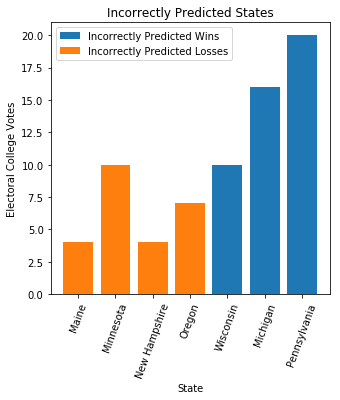

This model got 7 states wrong, making the accuracy 86.0%


In [19]:
#making a list of states this model got wrong
wrong_states=actual_results_2016_state[actual_results_2016_state['EC Votes']!=actual_results_2016_state['EC Votes Predicted']]

#plotting wrong states
wrong_states_grouped=wrong_states.sort_values(by="EC Votes")

from matplotlib import pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 5

plt.bar(x="State", height="EC Votes", data=wrong_states_grouped, label="Incorrectly Predicted Wins")
plt.bar(x="State", height="EC Votes Predicted", data=wrong_states_grouped, label="Incorrectly Predicted Losses")
plt.ylabel("Electoral College Votes")
plt.xlabel("State")
plt.title("Incorrectly Predicted States")
plt.xticks(rotation=70)
plt.legend()
plt.show()

print(f'This model got {len(wrong_states)} states wrong, making the accuracy {(1-len(wrong_states)/50)*100}%')

At first glance, this model seems to have performed really well. The model only got 7 states wrong, and just 2 of them were heavy-hitter states with >10 electoral college votes. However, some states are much easier to predict than others because they tend to favor a certain party regardless of election year. Meanwhile, due to the nature of the electoral college, some states are considered "swing states" because they do not lean heavily toward one party or another for any given election. As a result, these swing states tend to decide the fate of an election. At the time of the 2016 election, [Fivethirtyeight]("https://fivethirtyeight.com/features/the-odds-of-an-electoral-college-popular-vote-split-are-increasing/") listed 12 traditional swing states and 4 newer swing states:

Traditional
- Colorado, Florida, Iowa, Michigan, Minnesota, Nevada, New Hampshire, North Carolina, Ohio, Pennsylvania, Virginia, Wisconsin

New
- Arizona, Georgia, Maine, Utah

So, even though this model seems to have performed well overall, it is worthwhile to analyze how well the model did on swing states alone.

In [20]:
swing_states=['Colorado', 'Florida', 'Iowa', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Virginia', 'Wisconsin', 'Arizona', 'Georgia', 'Maine', 'Utah']
incorrect_swing_states=[i for i in wrong_states['State'].values if i in swing_states] 
print(f'This model got {(1-len(incorrect_swing_states)/len(swing_states))*100}% of the swing states correct. {len(incorrect_swing_states)} out of {len(wrong_states)} wrongly predicted states were swing states.')

This model got 62.5% of the swing states correct. 6 out of 7 wrongly predicted states were swing states.


As we can see, this model was much less effective than it first appeared. While the model was able to predict shoe-in states with ease, it was only able to predict 62.5% of states with less consistent voting patterns. It isn't very useful to have a model that primarily predicts easily predictable states, so ultimately this model needs some work. 

The model was built using only 2 elections worth of data, and the Democrats won these two elections. Thus, it is unsurprising that the model predicted the swing states incorrectly for 2016 considering how pivotal these states are for winning elections. The model would be greatly improved by including the results of many more of the most recent elections, with a mix of Republican and Democratic wins.

The model also relies on demographic data that stays static for 2008, 2012 and 2016. This is not realistic. The model would thus greatly improve with data that is specific to each election year. In sum, while the model was technically correct, it performs poorly on key assessments and would need to be retooled substantially if it were to be used for any future elections.